

# Understanding the camera calibration process

Use the *Rigid Body Tracking* package and the CoppeliaSim API to understand and analyze the image formation and the camera calibration problem. 

**Objective:** Represent the camera projection and use the virtual environment to compare the image points with the CoppeliaSim's visual sensor image.

---

## Mathematical foundation of the perspective camera


The point $p$ in the image plane is described by:
$$ x = f\frac{X}{Z}$$
$$ y = f\frac{Y}{Z}$$


Writing the point $p$ in homogenous coordinates: 
$$ \tilde{x} = fX $$
$$ \tilde{y} = fY $$
$$ \tilde{z} = Z $$

In matrix form: 

$$ \tilde{p} = \begin{pmatrix} f & 0 & 0\\ 0 &f  &0 \\ 0 & 0 &1 \end{pmatrix}
\cdot \begin{pmatrix} X\\ Y\\ Z \end{pmatrix} $$

Where the nonhomogeneous image-plane coordinates are: 

$$ x = \frac{\tilde{x}}{\tilde{z}} $$
$$ y = \frac{\tilde{y}}{\tilde{z}} $$


The world point P need to be written in respect to the camera coordinate frame. The coordinate vector of the world point with respect to the camera frame can be describe as: 

$${^CP}= {^OE_C} \cdot {^OP} $$ 

Where ${^OE_C}$ is the transformation matrix of the world coordinate frame to the camera coordinate frame. This transformation is describe as a rotation and a translation combined. 


Now, the perspective projection of a camera is: 

$$ \begin{pmatrix}
\tilde{x}\\ 
\tilde{y}\\ 
\tilde{z}
\end{pmatrix}= \begin{pmatrix}
f & 0 & 0\\ 
0 &f  &0 \\ 
0 & 0 &1 
\end{pmatrix}\cdot 
\begin{pmatrix}
{^CR_O} & {^Ct_O}\\ 
0 & 1
\end{pmatrix}
\begin{pmatrix}
X\\ 
Y\\ 
Z\\
1
\end{pmatrix}$$ 


$$ \tilde{p} = M_{int}\cdot M{ext}\cdot \tilde{P}$$ 

---




In CoppeliaSim, the camera is represented by the visual sensor. The focal length of the visual sensor can be determined based on the angle of view.

$$
        f = \frac{d}{2\tan (\frac{\theta}{2}) }
$$

Where $d$ is the sensor size in mm and $\theta$ is the angle of view. To find the focal length in pixels, consider the sensor size in pixels

\begin{align*}
        f_x &= \frac{R_x}{2\tan (\frac{\theta}{2})}\\
        f_y &= \frac{R_y}{2\tan (\frac{\theta}{2})}
\end{align*}

Considering the principal point of an image is in your center
\begin{align*}
        O_x &= \frac{R_x}{2} \\
        O_y &= \frac{R_y}{2}
\end{align*}

The intrinsic matrix is: 
\begin{equation*}
        K = \begin{pmatrix}
                f_x & 0 & O_x\\ 
                0 & f_y &O_y \\ 
                0 & 0 & 1   
            \end{pmatrix}
\end{equation*}

---

Extract the rotation and translation relating to the visual sensor frame using the CoppeliaSim Remote API


---

O que eu preciso refazer? 
- Refatorar todo o notebook
    - O que importa para mim neste momento
    - Dividir em pequenos programas que fazem poucas coisas
    

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

from cv2 import projectPoints, Rodrigues
from scripts.viewer import Viewer
from scripts.feed import Feed
from scripts.frame import Frame
from scripts.rigid import *
from scripts.camera import *

from coppeliasim_zmqremoteapi_client import RemoteAPIClient


### Generate random world points and see their projections in image plane

In [3]:
# Generate random point for scene 
number_of_points = 15
points_in_scene = generate_random_points(number_of_points)

# Reshape for better printing 
print("The random points are: \n", points_in_scene.T.reshape(number_of_points,3))

The random points are: 
 [[0.18497956 0.95761143 0.89104694]
 [0.13878012 0.991644   0.43288633]
 [0.11538491 0.28412912 0.29733795]
 [0.07977129 0.1803769  0.06074576]
 [0.49993888 0.27601491 0.36783403]
 [0.28534884 0.53285984 0.76088979]
 [0.64649173 0.86716322 0.98173716]
 [0.81236799 0.46091254 0.74095888]
 [0.19860635 0.02952618 0.95516166]
 [0.41232976 0.22448414 0.59154532]
 [0.14507507 0.28152644 0.97078187]
 [0.95230906 0.90568074 0.29743394]
 [0.51192782 0.83759604 0.96835265]
 [0.58770671 0.12191667 0.99716728]
 [0.1551243  0.72446008 0.82960715]]


### Plot the setup

In [4]:
def build_intrinsic_matrix(fov_degrees, resolution):
    fov_radians = np.radians(fov_degrees)

    f_x = resolution[0]/(2*np.tan(fov_radians/2))
    f_y = resolution[1]/(2*np.tan(fov_radians/2))

    o_x = resolution[0]/2
    o_y = resolution[1]/2

    camera_matrix = np.array([[-f_x,   0, o_x, 0],
                              [  0, -f_y, o_y, 0],
                              [  0,    0,   1, 0]])

    return camera_matrix

def build_extrinsic_matrix(vision_sensor_handle):
    camera_pose = np.vstack((np.array(sim.getObjectMatrix(vision_sensor_handle)).reshape((3,4)), np.array([0, 0, 0, 1])))

    return camera_pose

def build_projection_matrix(intrinsic_matrix, extrinsic_matrix):
    projection_matrix = intrinsic_matrix @ inverse_homo(extrinsic_matrix) 

    return projection_matrix

def perspective_projection(points, projection_matrix):
    projected_point = projection_matrix @ points  # Project points to plane
    projected_point /= projected_point[-1]        # Normalize homogeneous coordinates
    projected_point = projected_point[:-1, :]     # Discard the last row
    projected_point = projected_point.astype(int) # Cast as interger
    
    return projected_point

def distort_point(image_point, camera_matrix, radial_coefficients, tangential_coefficients):
    fx,fy = camera_matrix[0][0], camera_matrix[1][1]
    cx,cy = camera_matrix[0][2], camera_matrix[1][2]

    u,v = image_point.flatten()
    x,y = (u - cx)/fx, (v - cy)/fy

    normalized_image_point = np.array([[x],[y]])

    r = np.linalg.norm(normalized_image_point)

    k1, k2, k3, k4, k5, k6 = radial_coefficients
    p1, p2 = tangential_coefficients

    radial_component = normalized_image_point * (1 + k1*r**2 + k2*r**4 + k3*r**6)/(1 + k4*r**2 + k5*r**4 + k6*r**6)
    tangential_component = np.array([[2*p1*x*y + p2*(r**2 + 2*x**2)],
                                     [p1*(r**2 + 2*y**2) + 2*p2*x*y]])
 
    x_distorted, y_distorted = (radial_component + tangential_component).flatten()

    distorted_image_point = np.array([[x_distorted*fx + cx],
                                      [y_distorted*fy + cy]]).astype(int)
    return distorted_image_point

radial_coefficients = np.array([-0.11, -0.03, 0.009, 0.5, -0.07, 0.017])
tangential_coefficients = np.array([-0.0007, 0.00003])

# Declare intrinsic parameters
fov_degrees = 60.0
resolution = (480, 480)

# Generate intrinsic parameters matrix
intrinsic_matrix = build_intrinsic_matrix(fov_degrees, resolution) 
print(intrinsic_matrix)
client = RemoteAPIClient()
sim = client.getObject('sim')

# Get the vision sensor handle
vision_sensor_handle = sim.getObject('/Vision_sensor') 

# Generate extrinsic parameters matrix
extrinsic_matrix = build_extrinsic_matrix(vision_sensor_handle)

# Generate perspective projection matrix
projection_matrix = build_projection_matrix(intrinsic_matrix, extrinsic_matrix)

# 3D point to be projected in homogeneous coordinates
points_to_project = to_homo(cube()) # Vertices of a cube

# Change cube position
points_to_project[0] -= 0.25
points_to_project[1] -= 0.25
points_to_project[2] += 1

# Create the Scene Viewer
scene = Viewer('Camera Pose Scene', size = 5)

# Add elements to the scene
scene.add_frame(Frame(), 'World Frame', axis_size=0.2)
scene.add_frame(Frame(*split_homo(extrinsic_matrix)), 'Camera Frame', axis_size=0.2) 
scene.add_points(points_to_project, 'World Points', 'black')

# Plot scene
scene.figure.show(renderer='notebook_connected')

# Project the 3D point with the new pose
projected_points = perspective_projection(points_to_project, projection_matrix)

# Create the image viewer
image = Feed('Camera Image', resolution, graphical=True)

# Adding the projected points to the scene
image.add_points(projected_points, 'Image Point', 'black')

# Plot image
image.figure.show(renderer='notebook_connected')

# Print Results (Compare with simulation!)
print('Projected Points in Pixel Coordinates:')
print(projected_points)

#distorted_point = distort_point(projected_points.T[0], intrinsic_matrix, radial_coefficients, tangential_coefficients)

distorted_points = np.zeros((1,1))

for image_point in projected_points.T:
    point = distort_point(image_point, intrinsic_matrix, radial_coefficients, tangential_coefficients)
    distorted_point = np.array(point)
    distorted_points = np.append(distorted_points, distorted_point, axis = 0)


[[-415.69219382    0.          240.            0.        ]
 [   0.         -415.69219382  240.            0.        ]
 [   0.            0.            1.            0.        ]]


KeyboardInterrupt: 

In [ ]:
dl_cameramatrix = build_intrinsic_matrix(54.66666793823242, (480,480))
dl_cameramatrix

array([[-464.3284648,    0.       ,  240.       ,    0.       ],
       [   0.       , -464.3284648,  240.       ,    0.       ],
       [   0.       ,    0.       ,    1.       ,    0.       ]])

In [ ]:
distorted_points = np.array(([251,333],
                             [251,221],
                             [216,376],
                             [215,228],
                             [151,323],
                             [147,220],
                             [99,352],
                             [88,227]))

image.add_points(distorted_points.T, 'Distorted Image Points', 'blue')
image.figure.show(renderer='notebook_connected')

# Coppelia Enviroment

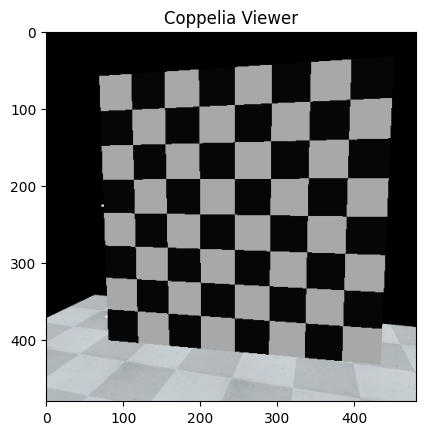

Detected Points in Pixel Coordinates:
[[ 78  73]
 [370 226]]


In [ ]:
# When simulation is not running, ZMQ message handling could be a bit
# slow, since the idle loop runs at 8 Hz by default. So let's make
# sure that the idle loop runs at full speed for this program:
defaultIdleFps = sim.getInt32Param(sim.intparam_idle_fps)   
sim.setInt32Param(sim.intparam_idle_fps, 0)
  
# Run a simulation in stepping mode:
sim.startSimulation()

point_cloud_handle = sim.createPointCloud(1, 1, 8, 3)
markers_color = list([255,255,255]) 

# Insert points into point cloud
points = np.concatenate(points_to_project[:-1, :].T)

points = points.tolist()

point_count = sim.insertPointsIntoPointCloud(point_cloud_handle, 0, points, markers_color)

coppelia_centroids = None
img = []

# Other blob detection method
while (t := sim.getSimulationTime()) < 1:
    img, resX, resY = sim.getVisionSensorCharImage(vision_sensor_handle)
    img = np.frombuffer(img, dtype=np.uint8).reshape(resY, resX, 3)

    # In CoppeliaSim images are left to right (x-axis), and bottom to top (y-axis)
    # (consistent with the axes of vision sensors, pointing Z outwards, Y up)
    # and color format is RGB triplets, whereas OpenCV uses BGR:
    img = cv2.flip(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0)
    
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Convert the grayscale image to binary image
    _,thresh = cv2.threshold(gray_image,230,255,0)

    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        # Calculate moments of each contour
        M = cv2.moments(c)
        
        # Calculate x,y coordinate of center
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            print('Point not detected!')
            break
        
        centroids = np.array([cX, cY]).reshape(-1,1)

        if coppelia_centroids is None:
            coppelia_centroids = centroids
        else:
            coppelia_centroids = np.hstack((coppelia_centroids, centroids))

    break # Just execute the first loop

# Restore the original idle loop frequency:
sim.setInt32Param(sim.intparam_idle_fps, defaultIdleFps)

sim.stopSimulation()

# Display the image
plt.imshow(img)
plt.title('Coppelia Viewer')
plt.show()

# Print Results (Compare with math model!)
print('Detected Points in Pixel Coordinates:')
print(coppelia_centroids)


## Calibrate your camera with DLT

In [ ]:
# Find the camera matrix [ndarray (3,4)] by computing DLT
dlt_camera_matrix = calibrate_camera(points_to_project[:-1,:].T, projected_points.T)

dlt_camera_matrix_distort = calibrate_camera(points_to_project[:-1,:].T, distorted_points)

estimated_image_points = perspective_projection(points_to_project,dlt_camera_matrix)
estimated_image_points_with_distortion = perspective_projection(points_to_project, dlt_camera_matrix_distort)

print("The ground truth camera matrix: \n", projection_matrix)

print("Estimated image points \n", estimated_image_points)
print("Estimated image points with distortion \n", estimated_image_points_with_distortion)
print("Ground truth projected points: \n", projected_points)

def reprojection_error (original_points, projected_points):

    reprojection_error = np.mean(np.linalg.norm(projected_points - original_points))
    print("The RMS Reprojection error is: \n", reprojection_error)
    return reprojection_error

reprojection_error(projected_points, estimated_image_points)
reprojection_error(projected_points, estimated_image_points_with_distortion)

# Create the image viewer
image = Feed('Camera Image', resolution, graphical=True)

# Adding the projected points to the scene
#image.add_points(estimated_image_points, 'Image Point', 'black')
image.add_points(estimated_image_points_with_distortion, 'Image Point DLT', 'blue')

# Plot image
image.figure.show(renderer='notebook_connected')




DLT camera matrix: 
 [[-2.71079760e-01 -2.70802495e-01 -1.61390625e-02  2.41667334e-01]
 [ 4.56325427e-02 -1.56420227e-01 -3.48390205e-01  8.04108413e-01]
 [ 2.19230934e-04 -7.73276947e-04 -6.84380772e-05  1.36385405e-03]]
DLT camera matrix: 
 [[ 2.22894393e-01  2.30154853e-01  4.09510988e-02 -2.78969385e-01]
 [-7.88335524e-02  1.22106972e-01  3.58699812e-01 -8.17344910e-01]
 [-3.56824396e-04  6.25669537e-04  1.72622208e-04 -1.50847533e-03]]
The ground truth camera matrix: 
 [[-3.39647627e+02 -3.38529102e+02 -2.09173783e+01  3.03041110e+02]
 [ 5.25031944e+01 -1.95944589e+02 -4.35027738e+02  1.00341542e+03]
 [ 2.57834160e-01 -9.62250187e-01 -8.71557427e-02  1.70012527e+00]]
Estimated image points 
 [[251 252 215 214 146 144  77  73]
 [337 220 386 228 327 219 369 226]]
Estimated image points with distortion 
 [[250 251 216 214 151 146  98  88]
 [334 220 374 228 321 220 352 227]]
Ground truth projected points: 
 [[252 252 215 215 146 144  78  73]
 [337 221 387 228 328 220 370 226]]
The RM

In [ ]:
# Define a new set of 3D points to project 

new_points_to_project = to_homo(cube()) # Vertices of a cube
new_points_to_project[0] -= 0.4
new_points_to_project[1] -= 0.2
new_points_to_project[2] += 1.3

# Project the generated points 

# Ground Truth 
new_projected_points = perspective_projection(new_points_to_project, projection_matrix)
print(new_projected_points, "\n")

# Using the DLT camera matrix
new_projected_points_DLT = perspective_projection(new_points_to_project, dlt_camera_matrix)

print(new_projected_points_DLT)

# Create the image viewer
image = Feed('Camera Image', resolution, graphical=True)

# Adding the projected points to the scene
image.add_points(new_projected_points, 'Image Point', 'black')
image.add_points(new_projected_points_DLT, 'Image Point DLT', 'yellow')

# Plot image
image.figure.show(renderer='notebook_connected')


[[286 287 259 260 171 169 105 101]
 [272 146 299 122 267 150 290 130]] 

[[285 286 259 260 170 169 105 101]
 [271 145 299 121 266 150 290 130]]


In [ ]:
dummy = sim.getObjectHandle('/Cuboid')
transf_matrix_dummy = build_extrinsic_matrix(dummy)

    
def construct3DPoints(patternSize,squareSize):
    X = np.zeros((patternSize[0]*patternSize[1],3), np.float32)
    X[:,:2] = np.mgrid[0:patternSize[0],0:patternSize[1]].T.reshape(-1,2)
    X = X * squareSize
    return X

patternSize = (7,7)
squareSize = (0.3)

boardPoints = construct3DPoints(patternSize,squareSize)

boardPoints_homo = to_homo(boardPoints.T)

dislocated_boardPoints = transf_matrix_dummy @ boardPoints_homo
dislocated_boardPoints = dislocated_boardPoints[:-1:]

sim.startSimulation()

point_cloud_handle = sim.createPointCloud(1, 1, 8, 3)
markers_color = list([255,255,255]) 

# Insert points into point cloud
points = np.concatenate(dislocated_boardPoints)

points = points.tolist()

point_count = sim.insertPointsIntoPointCloud(point_cloud_handle, 0, points, markers_color)

sim.stopSimulation()


In [ ]:
sim.startSimulation()

n = 6

while (t := sim.getSimulationTime()) < 1:
    img, resX, resY = sim.getVisionSensorCharImage(vision_sensor_handle)
    img = np.frombuffer(img, dtype=np.uint8).reshape(resY, resX, 3)

    # In CoppeliaSim images are left to right (x-axis), and bottom to top (y-axis)
    # (consistent with the axes of vision sensors, pointing Z outwards, Y up)
    # and color format is RGB triplets, whereas OpenCV uses BGR:
    img = cv2.flip(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0)

    cv2.imwrite(f'image{n}.jpg',img)
    cv2.destroyAllWindows()

sim.stopSimulation()

KeyboardInterrupt: 

In [ ]:
def construct3DPoints(patternSize,squareSize):
    X = np.zeros((patternSize[0]*patternSize[1],3), np.float32)
    X[:,:2] = np.mgrid[0:patternSize[0],0:patternSize[1]].T.reshape(-1,2)
    X = X * squareSize
    return X

patternSize = (7,7)
squareSize = 10
imgSize = (480,480)

boardPoints = construct3DPoints(patternSize=(7,7),squareSize=10)
worldPoints = []
imagePoints = [] 

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

images = glob.glob('*.jpg')
print(images)

counter = 0
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCornersSB(gray, patternSize, None)
    if ret == True:
        print("Corners found in image" + str(fname)) #- see if corners are found 
        imagePoints.append(corners)
        worldPoints.append(boardPoints)
        counter+=1

print("using " + str(counter) + " images")

flagsCalib =cv2.CALIB_FIX_PRINCIPAL_POINT + cv2.CALIB_SAME_FOCAL_LENGTH 
ret, cameraMatrix, k, rvecs, tvecs = cv2.calibrateCamera(worldPoints, imagePoints, imgSize, None, None,flags=flagsCalib)

print("Using "+str(counter)+" of "+str(len(images))+" images")
print("RMS re-projection error:", ret)
print("Camera Matrix:\n", cameraMatrix)
print("Distortion coefficients: ", k)

print("Estimated intrinsic camera matrix using OpenCV: \n", cameraMatrix)
print("Original intrinsic matrix: \n", intrinsic_matrix)

['image4.jpg', 'image1.jpg', 'image6.jpg', 'image2.jpg', 'image3.jpg', 'image5.jpg']
Corners found in imageimage4.jpg
Corners found in imageimage1.jpg
Corners found in imageimage6.jpg
Corners found in imageimage2.jpg
Corners found in imageimage3.jpg
Corners found in imageimage5.jpg
using 6 images
Using 6 of 6 images
RMS re-projection error: 0.21324142799197696
Camera Matrix:
 [[417.09543482   0.         239.5       ]
 [  0.         417.08837463 239.5       ]
 [  0.           0.           1.        ]]
Distortion coefficients:  [[ 0.0035729  -0.02856468 -0.00027219 -0.00023397  0.03493541]]
Estimated intrinsic camera matrix using OpenCV: 
 [[417.09543482   0.         239.5       ]
 [  0.         417.08837463 239.5       ]
 [  0.           0.           1.        ]]
Original intrinsic matrix: 
 [[-415.69219382    0.          240.            0.        ]
 [   0.         -415.69219382  240.            0.        ]
 [   0.            0.            1.            0.        ]]
